In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

# ==========================================
# 1. FIND YOUR DATASET
# ==========================================
# Kaggle puts uploads in /kaggle/input/
# We search for the folder that contains your 'biodegradable' class
input_root = "/kaggle/input"
data_dir = None

print("🔍 Searching for your uploaded dataset...")
for root, dirs, files in os.walk(input_root):
    if "biodegradable" in dirs and "non_biodegradable" in dirs:
        data_dir = root
        print(f"✅ Found dataset at: {data_dir}")
        break

if data_dir is None:
    print("❌ Error: Could not find 'biodegradable' and 'non_biodegradable' folders.")
    print("Did you upload the zip correctly? Check the /kaggle/input folder in the sidebar.")
    # Stop execution if data isn't found
    raise FileNotFoundError("Dataset not found!")

# ==========================================
# 2. SETUP & TRANSFORMS
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Preprocessing for MobileNet
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# ==========================================
# 3. LOAD DATA (CORRECTED)
# ==========================================
import torch
from torch.utils.data import DataLoader, Subset

print("📂 Loading images...")

# 1. Load the dataset TWICE with different transforms
# One copy applies augmentation (Training)
full_train_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
# One copy is clean (Validation)
full_val_dataset = datasets.ImageFolder(data_dir, transform=val_transforms)

# 2. Create Split Indices
total_count = len(full_train_dataset)
train_count = int(0.8 * total_count)
val_count = total_count - train_count

# Generate random indices
indices = torch.randperm(total_count).tolist()
train_indices = indices[:train_count]
val_indices = indices[train_count:]

# 3. Create Subsets using the CORRECT parent datasets
train_data = Subset(full_train_dataset, train_indices)
val_data = Subset(full_val_dataset, val_indices)

# 4. Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)

print(f"Classes: {full_train_dataset.classes}")
print(f"Training on {len(train_data)} images")
print(f"Validating on {len(val_data)} images")

# ==========================================
# 4. MODEL SETUP (MobileNetV4)
# ==========================================
# Kaggle usually has 'timm' installed, but we ensure it here
try:
    import timm
except ImportError:
    import os
    os.system('pip install timm')
    import timm

print("⬇️ Loading MobileNetV4...")
model = timm.create_model('mobilenetv4_conv_small.e2400_r224_in1k', pretrained=True, num_classes=2)
model = model.to(device)

# ==========================================
# 5. IMPROVED TRAINING (With Scheduler)
# ==========================================
# 1. We change the Transform to SQUISH instead of CROP (Better for trash)
train_data.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Squish entire image to square
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),       # Increased rotation
    transforms.ColorJitter(0.3, 0.3),    # Increased lighting variance
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# 2. Lower Initial Learning Rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Changed from 0.001 to 0.0001

# 3. Add Scheduler (The Secret Weapon)
# Every 3 epochs, it cuts the speed in half.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

scaler = torch.cuda.amp.GradScaler() 

EPOCHS = 15 # Increased slightly to let the scheduler work

print(f"\n🚀 Starting Improved Training for {EPOCHS} epochs...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Update the learning rate speed
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
        
    print(f"Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | Loss: {running_loss/len(train_loader):.4f} | Acc: {100 * correct / total:.2f}%")

# Save model
save_path = "/kaggle/working/my_improved_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\n🎉 Done! Saved to: {save_path}")

# ==========================================
# 6. SAVE MODEL
# ==========================================
# In Kaggle, you MUST save to /kaggle/working/ to download it later
save_path = "/kaggle/working/my_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\n🎉 Training Complete! Model saved to: {save_path}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

🔍 Searching for your uploaded dataset...
✅ Found dataset at: /kaggle/input/waste-classification
Using Device: cuda
📂 Loading images...
Classes: ['biodegradable', 'non_biodegradable']
Training on 19963 images
Validating on 4991 images
⬇️ Loading MobileNetV4...


model.safetensors:   0%|          | 0.00/15.2M [00:00<?, ?B/s]


🚀 Starting Improved Training for 15 epochs...


/tmp/ipykernel_47/329002543.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_47/329002543.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15 | LR: 0.000100 | Loss: 0.8866 | Acc: 82.18%
Epoch 2/15 | LR: 0.000100 | Loss: 0.2959 | Acc: 88.05%
Epoch 3/15 | LR: 0.000050 | Loss: 0.2446 | Acc: 90.37%
Epoch 4/15 | LR: 0.000050 | Loss: 0.2032 | Acc: 92.12%
Epoch 5/15 | LR: 0.000050 | Loss: 0.1913 | Acc: 92.59%
Epoch 6/15 | LR: 0.000025 | Loss: 0.1728 | Acc: 93.39%
Epoch 7/15 | LR: 0.000025 | Loss: 0.1604 | Acc: 93.81%
Epoch 8/15 | LR: 0.000025 | Loss: 0.1350 | Acc: 94.76%
Epoch 9/15 | LR: 0.000013 | Loss: 0.1317 | Acc: 95.09%
Epoch 10/15 | LR: 0.000013 | Loss: 0.1181 | Acc: 95.56%
Epoch 11/15 | LR: 0.000013 | Loss: 0.1072 | Acc: 95.99%
Epoch 12/15 | LR: 0.000006 | Loss: 0.1030 | Acc: 95.98%
Epoch 13/15 | LR: 0.000006 | Loss: 0.0952 | Acc: 96.50%
Epoch 14/15 | LR: 0.000006 | Loss: 0.0888 | Acc: 96.73%
Epoch 15/15 | LR: 0.000003 | Loss: 0.0878 | Acc: 96.67%

🎉 Done! Saved to: /kaggle/working/my_improved_model.pth

🎉 Training Complete! Model saved to: /kaggle/working/my_model.pth


Confusion Matrix Generation

Classes: ['biodegradable', 'non_biodegradable']
Running inference to build Confusion Matrix...


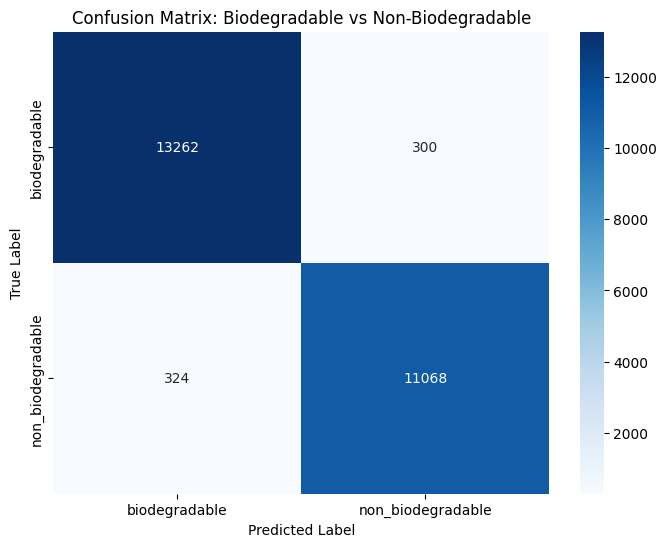


Classification Report:

                   precision    recall  f1-score   support

    biodegradable       0.98      0.98      0.98     13562
non_biodegradable       0.97      0.97      0.97     11392

         accuracy                           0.97     24954
        macro avg       0.97      0.97      0.97     24954
     weighted avg       0.97      0.97      0.97     24954



In [3]:
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP
# ==========================================
MODEL_PATH = "/kaggle/working/my_improved_model.pth"
DATA_DIR = "/kaggle/input/waste-classification" # Point to your MAIN dataset
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. PREPARE DATA
# ==========================================
# We use the standard validation transform (No augmentation)
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),       # Match training size
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Load dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=val_transforms)
class_names = full_dataset.classes
print(f"Classes: {class_names}")

# Create a loader (We'll scan the whole dataset to be thorough)
loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==========================================
# 3. LOAD MODEL
# ==========================================
model = timm.create_model('mobilenetv4_conv_small.e2400_r224_in1k', pretrained=False, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

# ==========================================
# 4. GENERATE PREDICTIONS
# ==========================================
y_true = []
y_pred = []

print("Running inference to build Confusion Matrix...")
with torch.no_grad():
    for inputs, labels in loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ==========================================
# 5. PLOT CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Biodegradable vs Non-Biodegradable')
plt.show()

# ==========================================
# 6. PRINT REPORT
# ==========================================
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Testing file

In [2]:
import os
import torch
import timm
from PIL import Image
from torchvision import transforms

# ==========================================
# 1. SETUP PATHS
# ==========================================
# Change this to the folder containing your test images
TEST_DIR = "/kaggle/input/test-data/images"

# Change this to your trained model path
MODEL_PATH = "/kaggle/working/my_improved_model.pth"

# ==========================================
# 2. LOAD THE MODEL
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# We must create the exact same model structure as before
model = timm.create_model('mobilenetv4_conv_small.e2400_r224_in1k', pretrained=False, num_classes=2)

# Load the weights you saved
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("✅ Model loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: Could not find model at {MODEL_PATH}")
    print("Did you finish training and save it?")
    exit()

model = model.to(device)
model.eval() # Important: Switch to evaluation mode (turns off dropout/batchnorm updates)

# ==========================================
# 3. DEFINE TRANSFORMS (Must match validation)
# ==========================================
# Standard ImageNet normalization
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Classes (Make sure these match your training order!)
# Usually, ImageFolder sorts alphabetically:
class_names = ['Biodegradable', 'Non-Biodegradable'] 

# ==========================================
# 4. RUN INFERENCE
# ==========================================
print(f"\nScanning images in: {TEST_DIR}...\n")

if not os.path.exists(TEST_DIR):
    print(f"❌ Error: Test folder '{TEST_DIR}' does not exist.")
    print("Please create it and upload some images to test!")
else:
    image_files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print("⚠️ No images found in the folder.")
    
    print(f"{'FILENAME':<30} | {'PREDICTION':<20} | {'CONFIDENCE':<10}")
    print("-" * 70)

    for img_name in image_files:
        img_path = os.path.join(TEST_DIR, img_name)
        
        try:
            # Open Image
            img = Image.open(img_path).convert('RGB')
            
            # Preprocess
            input_tensor = preprocess(img).unsqueeze(0).to(device) # Add batch dimension
            
            # Predict
            with torch.no_grad():
                output = model(input_tensor)
                
                # Convert logits to probabilities
                probs = torch.nn.functional.softmax(output, dim=1)
                
                # Get the winner
                score, predicted_idx = torch.max(probs, 1)
                
                label = class_names[predicted_idx.item()]
                confidence = score.item() * 100
                
            print(f"{img_name:<30} | {label:<20} | {confidence:.2f}%")
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")

Using Device: cuda
✅ Model loaded successfully!

Scanning images in: /kaggle/input/test-data/images...

FILENAME                       | PREDICTION           | CONFIDENCE
----------------------------------------------------------------------
plastic477_jpg.rf.0e5cf5f0aa12b659ceb0d9dff33edc8a.jpg | Non-Biodegradable    | 99.63%
plastic999_jpg.rf.d6f8fc1a8acc7875177dd0a0215c487b.jpg | Non-Biodegradable    | 100.00%
paper1713_jpeg.rf.440f804d53b2ab8d8c1eec8957a88536.jpg | Non-Biodegradable    | 98.46%
paper1970_jpg.rf.9d3042fdcde02cb455aa1af54cf77000.jpg | Biodegradable        | 90.88%
paper1964_jpg.rf.bb2e063aa39767d1884703f1ce8f84df.jpg | Non-Biodegradable    | 61.35%
paper157_jpg.rf.c0ce38237cb7a257216570af3e332720.jpg | Biodegradable        | 99.27%
plastic1065_jpg.rf.02d4099b0ef672bb9937195616b1eac5.jpg | Non-Biodegradable    | 99.42%
paper13_jpg.rf.720e3c8ecd2d18a4dc4b607b307bd95e.jpg | Biodegradable        | 96.92%
paper1138_jpg.rf.277c196770398f65b47df74ebbe39d5c.jpg | Non-Biodegr